# Stable Diffusion using Diffusers Library from Hugging Face

In [1]:
!pip install --upgrade diffusers
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
from base64 import b64encode
from IPython.display import HTML
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
from google.colab import output


import torch
from torch import autocast
from torch.nn import functional as F

from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
safety_checker/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [10]:
prompt = 'A train going through a scenic valley digital art'
with autocast(device):
  image = pipe(prompt, num_inference_steps=20)
image

  0%|          | 0/20 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7AF18C413D90>], nsfw_content_detected=[False])

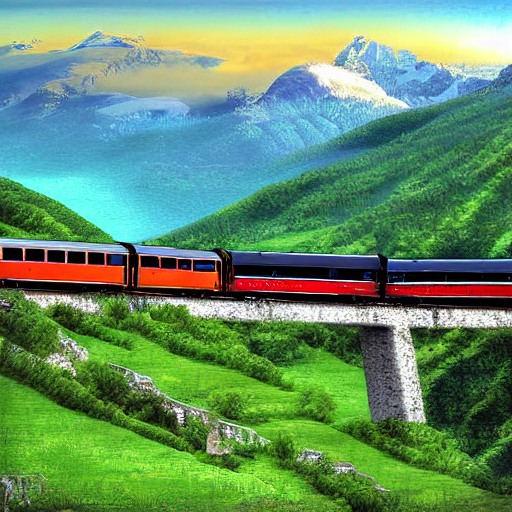

In [11]:
image.images[0]

# Create a Video from Blur to Final Image

#### Tokenzier and the CLIP Model

In [3]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

#### Method to use the Tokenizer and the CLIP model

In [4]:
def get_text_embeds(prompt):
  # Tokenization
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Unconditional Embeddings for Classifier-free Guidance
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Concatenate the Embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

In [5]:
embeds = get_text_embeds('train in a valley')

#### U-Net Model to convert Embeddings into vectors in latent Space

In [6]:
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

### Scheduler for Noise Generation

In [7]:
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [8]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.init_noise_sigma

  latent_hist = [latents]
  with autocast('cuda'):
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        latent_hist.append(latents)

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

#### Auto-Encoder to Convert Latent Vectors back to Images

In [9]:
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [10]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents).sample

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

In [20]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=20,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

In [24]:
all_imgs = prompt_to_img(prompts='A train going through a scenic valley digital art', num_inference_steps=50)

<ipython-input-8-417674aa5641>:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [25]:
len(all_imgs)

51

In [31]:
import matplotlib.pyplot as plt

def display_image_grid(images, cols=5, figsize=(15, 15)):
    """
    Display a list of images in a grid using Matplotlib.

    Args:
        images (list): List of PIL Image objects.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    # Calculate the number of rows needed
    rows = len(images) // cols + int(len(images) % cols != 0)

    # Create a new figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize, gridspec_kw={'hspace': 0.01, 'wspace': 0.01})

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Iterate over the images and plot them
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')  # Hide the axes

    # Remove any empty subplots
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig('./output.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [32]:
display_image_grid(all_imgs[1:])

In [33]:
!output.png

/bin/bash: line 1: output.png: command not found
